In [278]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
import nltk
%matplotlib inline

In [4]:
risk_qa = pd.read_excel("risk_data.xlsx")

In [18]:
risk_qa.head()

,客戶編號,風險等級,風險等級分類,適性評量填寫日期,適性版號,題目序號,KYC_QUESTION,ANS_ORDER,ANS_ITEM,答題得分,客戶職業與任職部門,AGENT代碼
0,261909,5,積極型,2018-10-30 22:54:34.523,201809A,A0,是否為其他國家稅務居住者?,1,1.否,0,NaN,9999999999
1,261909,5,積極型,2018-10-30 22:54:34.523,201809A,A01,職業／行業別,8,8.退休人士,0,NaN,9999999999
2,261909,5,積極型,2018-10-30 22:54:34.523,201809A,A02,職務,1,1.基層職員,0,NaN,9999999999
3,261909,5,積極型,2018-10-30 22:54:34.523,201809A,A03,任職單位,1,1.任職公司／機構,0,寶豐,9999999999
4,261909,5,積極型,2018-10-30 22:54:34.523,201809A,A03,任職單位,2,2.任職部門,0,營建,9999999999


In [8]:
uni_id = np.unique(risk_qa["客戶編號"])

In [41]:
attr_dict = defaultdict(lambda: defaultdict(list))
max_ans_dict = defaultdict(int) # record max answer num for each question (for one-hot array)

for index, row in risk_qa.iterrows():
    attr_dict[row["客戶編號"]][row["題目序號"]].append(row["ANS_ORDER"])
    if max_ans_dict[row["題目序號"]]<row["ANS_ORDER"]:
        max_ans_dict[row["題目序號"]] = row["ANS_ORDER"] 

In [45]:
question_list = list(max_ans_dict.keys())

In [67]:
# create feature matrix (one-hot encoding)
feature_matrix = []
id_list = []
for user in attr_dict.keys():
    single_user_feature = []
    for q in question_list:
        ans = np.array(attr_dict[user][q])-1
        one_hot = np.zeros(max_ans_dict[q])
        if len(ans)!=0:
            one_hot[ans] = 1
        single_user_feature.append(one_hot)
    merge_feature = np.hstack(single_user_feature)
    feature_matrix.append(merge_feature)
    id_list.append(user)
feature_matrix = np.vstack(feature_matrix)

In [69]:
feature_matrix.shape

(1884, 121)

In [279]:
X = feature_matrix
X_embedded = TSNE(n_components=2, perplexity=80).fit_transform(X)
X_embedded = PCA(n_components=2).fit_transform(X)

X_embedded.shape

(1884, 2)

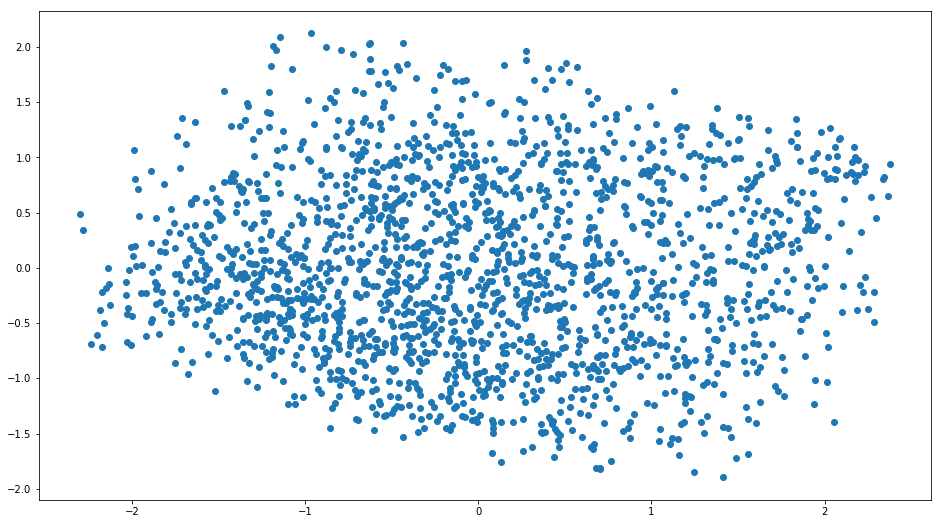

In [280]:
plt.figure(figsize=(16,9))
# cm = plt.cm.get_cmap("tab20", 18)
sc = plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.show()

# 實際投資行為

In [281]:
invest = pd.read_excel("invest_data.xlsx")

In [282]:
invest["weight"] = invest["風險等級"].apply(lambda x:int(x[-1]))
invest["weight_amount"] = invest["weight"]*invest["金額"]

In [283]:
customer = list(set(invest["客戶"]))
customer_count = invest.groupby('客戶',as_index=False, sort=False).count()
customer_total = invest.groupby('客戶',as_index=False, sort=False).sum()
customer_total.head()

,客戶,金額,weight,weight_amount
0,100066,601432,57,2261432
1,100542,3000,4,12000
2,100558,12000,18,57000
3,100606,12000,17,51000
4,100657,5000,4,20000


In [284]:
customer_total["weight_level"] = customer_total["weight_amount"]/customer_total["金額"]

In [285]:
customer_total.head()

,客戶,金額,weight,weight_amount,weight_level
0,100066,601432,57,2261432,3.760079
1,100542,3000,4,12000,4.000000
2,100558,12000,18,57000,4.750000
3,100606,12000,17,51000,4.250000
4,100657,5000,4,20000,4.000000


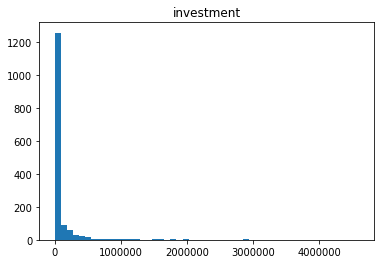

In [286]:
plt.hist(customer_total["金額"], bins=50)
# plt.xlim(0,50000)
plt.title("investment")
plt.show()

In [287]:
sum(customer_money["金額"]<400000)/len(customer_money)

1.0

In [288]:
customer_money.loc[customer_money["客戶"]==c, "風險等級"].values[0]

1

In [289]:
vis_vec = []
amount = []
risk_level = []
for c in customer:
    money = customer_total.loc[customer_total["客戶"]==c, "金額"].values[0]
    level = customer_total.loc[customer_total["客戶"]==c, "weight_level"].values[0]
    if money<100000:
        vis_vec.append(X_embedded[id_list.index(c)])
        amount.append(money)
        risk_level.append(level)
vis_vec = np.vstack(vis_vec)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


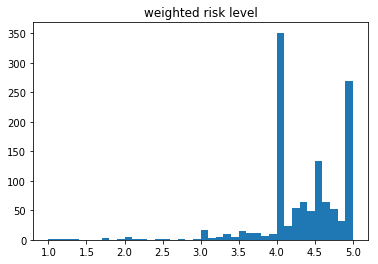

In [290]:
plt.hist(risk_level,bins=40)
plt.title("weighted risk level")
plt.show()

In [291]:
amount = (np.array(amount)-min(amount))/(max(amount)-min(amount))

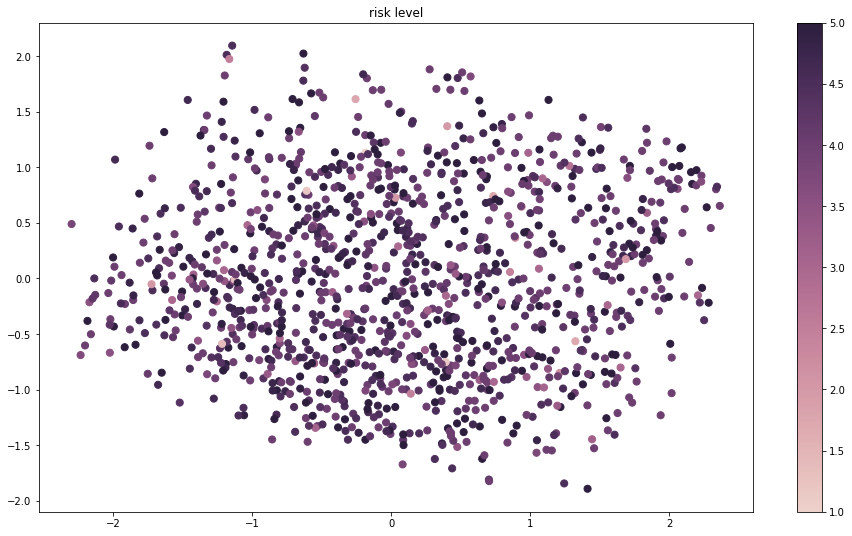

In [292]:
cmap = sns.cubehelix_palette(as_cmap=True)

f, ax = plt.subplots(figsize=(16,9))
points = ax.scatter(vis_vec[:,0], vis_vec[:,1], c=risk_level, s=50, cmap=cmap)
f.colorbar(points)
plt.title("risk level")
plt.show()

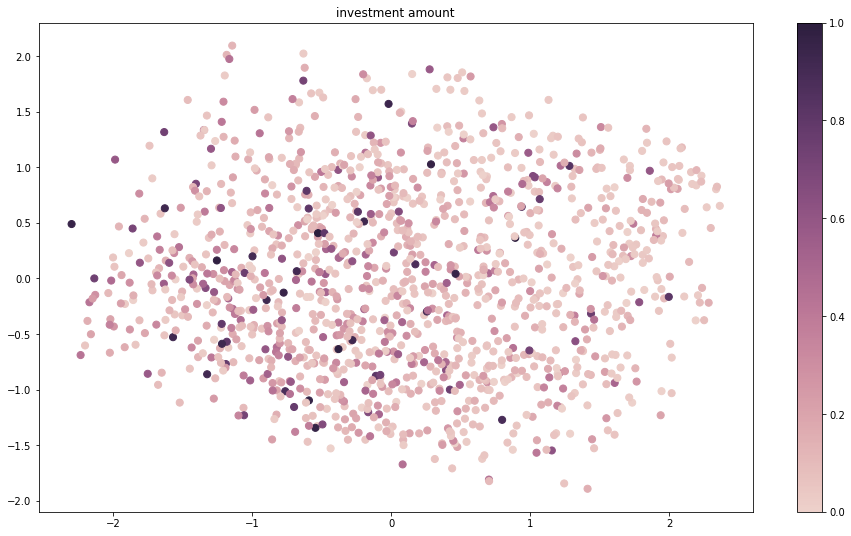

In [293]:
cmap = sns.cubehelix_palette(as_cmap=True)

f, ax = plt.subplots(figsize=(16,9))
points = ax.scatter(vis_vec[:,0], vis_vec[:,1], c=amount, s=50, cmap=cmap)
f.colorbar(points)
plt.title("investment amount")
plt.show()

# 產品名稱

In [259]:
product_corpus = "".join(list(invest["基金簡稱"]))

In [267]:
jieba.set_dictionary('C:/Users/thtang/Desktop/dict.txt.big.txt')

In [268]:
product_words = jieba.lcut(product_corpus)

Building prefix dict from C:\Users\thtang\Desktop\dict.txt.big.txt ...
Dumping model to file cache C:\Users\thtang\AppData\Local\Temp\jieba.uba0a17a1be2ddd4fd473d325f92d303f.cache
Loading model cost 1.215 seconds.
Prefix dict has been built succesfully.


In [277]:
" ".join(product_words).replace("基金","").replace("野村","")

' 優質  - 累積 類型 新臺幣 計價    e 科技   中小  - 累積 類型  全球 高 股息  - 累積 型 新臺幣 計價  精選 貨幣 市場   全球 生技 醫療   新興 傘型 之大 俄羅斯   中國 機會   全球 美元 投資 級 公司債  - 累積 型  巴西 證券 投資信託   雙印 傘型 之 印尼 潛力   亞太 複合 高 收益 債  - 累積 型 新臺幣 計價  全球 短期 收益  - 新台幣 計價  多元 收益 平衡  - 累積 類型 新臺幣 計價  亞太 新興 債券  - 累積 類型 新臺幣 計價  環球  - 新臺幣 計價  中小  - 累積 類型  台灣 運籌   全球 生技 醫療   中國 機會   優質  - 累積 類型 新臺幣 計價  全球 高 股息  - 累積 型 新臺幣 計價  台灣 運籌   巴西 證券 投資信託   全球 高 股息  - 累積 型 新臺幣 計價  優質  - 累積 類型 新臺幣 計價  中小  - 累積 類型  全球 不動產 證券化  - 累積 型 新臺幣 計價  台灣 運籌   新馬   台灣 高 股息   全球 生技 醫療   新興 傘型 之大 俄羅斯   中國 機會   雙印 傘型 之 印度 潛力   雙印 傘型 之 印尼 潛力   亞太 複合 高 收益 債  - 累積 型 新臺幣 計價  歐洲 中小 成長  - 累積 類型 新臺幣 計價  全球 短期 收益  - 新台幣 計價  亞太 新興 債券  - 累積 類型 新臺幣 計價  亞太 新興 債券  - 累積 類型 新臺幣 計價  亞太 新興 債券  - 累積 類型 新臺幣 計價  中小  - 累積 類型  環球  - 新臺幣 計價  貨幣 市場   泰國   全球 生技 醫療   新興 傘型 之大 俄羅斯   雙印 傘型 之 印尼 潛力   亞太 複合 高 收益 債  - 累積 型 新臺幣 計價  亞太 複合 高 收益 債  - 月 配型 新臺幣 計價  歐洲 中小 成長  - 累積 類型 新臺幣 計價    e 科技   中小  - 累積 類型  環球  - 新臺幣 計價  全球 生技 醫療   中國 機會   雙印 傘型 之 印度 潛力   雙印 傘型 之 印尼 潛力   新興 傘型 之大 俄羅斯   中國 機會   優質  - 累積 類型 

In [272]:
freq = nltk.FreqDist(product_words)

In [274]:
freq.most_common()

[('基金', 5853),
 ('野村', 5820),
 ('-', 2354),
 ('計價', 1694),
 ('新臺幣', 1639),
 ('累積', 1376),
 ('類型', 1329),
 ('全球', 964),
 ('傘型', 893),
 ('高', 672),
 ('收益', 653),
 ('新興', 632),
 ('之', 553),
 ('環球', 481),
 ('中國', 444),
 ('雙印', 435),
 ('潛力', 435),
 ('生技', 426),
 ('醫療', 426),
 ('債', 423),
 ('中小', 400),
 ('機會', 397),
 ('之大', 340),
 ('俄羅斯', 340),
 ('亞太', 336),
 ('台灣', 328),
 ('證券', 310),
 ('投資信託', 310),
 ('型', 309),
 ('泰國', 308),
 ('股息', 279),
 ('印度', 259),
 ('優質', 256),
 ('成長', 246),
 ('巴西', 244),
 ('運籌', 226),
 ('品牌', 220),
 ('複合', 202),
 ('印尼', 176),
 ('歐洲', 172),
 ('配型', 169),
 ('月', 158),
 ('月配', 148),
 ('平衡', 142),
 (' ', 137),
 ('e', 137),
 ('科技', 137),
 ('債券', 136),
 ('日本', 130),
 ('領先', 130),
 ('高科技', 128),
 ('組合', 115),
 ('S', 109),
 ('新馬', 108),
 ('多重', 100),
 ('資產', 100),
 ('多元', 89),
 ('不動產', 86),
 ('證券化', 86),
 ('短期', 83),
 ('新台幣', 83),
 ('配置', 82),
 ('市場', 75),
 ('鑫', 73),
 ('動態', 67),
 ('美利堅', 66),
 ('積極', 63),
 ('貨幣', 61),
 ('?', 59),
 ('鴻運', 56),
 ('中東', 55),
 ('非洲', 55),
 ('